In [ ]:
!pip install -q segmentation-models-pytorch==0.3.3 torchmetrics==1.4.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 80.1 MB/s eta 0:00:00


In [ ]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as T
from torchvision.datasets import VOCSegmentation

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

In [ ]:
from google.colab import files
files.upload()

Saving kaggle (1).json to kaggle (1).json


{'kaggle (1).json': b'{"username":"arsen1256","key":"b9ab2638d1ba43a45f6ac3d93ada4a60"}'}

In [ ]:
!pip install -q kaggle

import os, shutil

os.makedirs("/root/.kaggle", exist_ok=True)
shutil.move("kaggle (1).json", "/root/.kaggle/kaggle.json")
os.chmod("/root/.kaggle/kaggle.json", 0o600)

!ls /root/.kaggle

kaggle.json


In [ ]:
!mkdir -p data
!kaggle datasets download -d huanghanchina/pascal-voc-2012 -p data

Dataset URL: https://www.kaggle.com/datasets/huanghanchina/pascal-voc-2012
License(s): DbCL-1.0
 99% 3.61G/3.63G [01:10<00:00, 255MB/s]
100% 3.63G/3.63G [01:10<00:00, 55.6MB/s]


In [ ]:
!unzip -q data/pascal-voc-2012.zip -d data
!ls data
!ls data/VOC2012

pascal-voc-2012.zip  voc2012  VOC2012
Annotations  ImageSets	JPEGImages  SegmentationClass  SegmentationObject


In [ ]:
IMG_SIZE = 256
NUM_CLASSES = 21
IGNORE_INDEX = 255

# Трансформация изображений
img_transform = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Трансформация маски
class MaskTransform:
    def __call__(self, mask):
        mask = mask.resize((IMG_SIZE, IMG_SIZE), Image.NEAREST)
        mask = np.array(mask, dtype=np.int64)
        return torch.from_numpy(mask)

mask_transform = MaskTransform()


class VOCDataset(Dataset):
    def __init__(self, root, image_set="train"):
        self.root = root

        split_file = os.path.join(root, "ImageSets", "Segmentation", f"{image_set}.txt")
        with open(split_file) as f:
            self.ids = [x.strip() for x in f.readlines()]

        self.img_dir = os.path.join(root, "JPEGImages")
        self.mask_dir = os.path.join(root, "SegmentationClass")

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        img_id = self.ids[idx]

        img = Image.open(os.path.join(self.img_dir, img_id + ".jpg")).convert("RGB")
        mask = Image.open(os.path.join(self.mask_dir, img_id + ".png"))

        return img_transform(img), mask_transform(mask)

In [ ]:
train_dataset = VOCDataset("/content/data/VOC2012", "train")
val_dataset   = VOCDataset("/content/data/VOC2012", "val")

len(train_dataset), len(val_dataset)

(1464, 1449)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2)

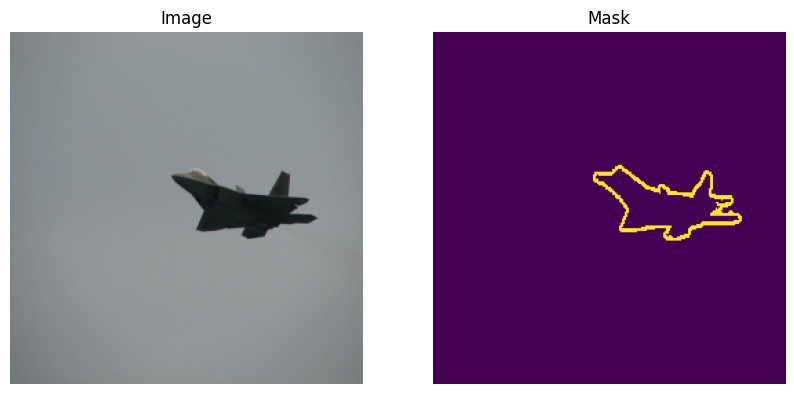

In [ ]:
imgs, masks = next(iter(train_loader))

# привести картинку к нормальному виду
mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
std  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
img_vis = (imgs[0] * std + mean).permute(1,2,0).clamp(0,1).numpy()

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(img_vis)
plt.title("Image")
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(masks[0])
plt.title("Mask")
plt.axis("off")
plt.show()

In [ ]:
import torch.nn.functional as F

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.layers(x)


# U-Net
class UNet(nn.Module):
    def __init__(self, n_classes=21):
        super().__init__()

        self.down1 = DoubleConv(3, 64)
        self.down2 = DoubleConv(64, 128)
        self.down3 = DoubleConv(128, 256)
        self.down4 = DoubleConv(256, 512)

        self.pool = nn.MaxPool2d(2)

        self.bottleneck = DoubleConv(512, 1024)

        self.up4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = DoubleConv(1024, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = DoubleConv(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = DoubleConv(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = DoubleConv(128, 64)

        self.final = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        c1 = self.down1(x)
        c2 = self.down2(self.pool(c1))
        c3 = self.down3(self.pool(c2))
        c4 = self.down4(self.pool(c3))

        bn = self.bottleneck(self.pool(c4))

        u4 = self.up4(bn)
        u4 = torch.cat([u4, c4], dim=1)
        d4 = self.dec4(u4)

        u3 = self.up3(d4)
        u3 = torch.cat([u3, c3], dim=1)
        d3 = self.dec3(u3)

        u2 = self.up2(d3)
        u2 = torch.cat([u2, c2], dim=1)
        d2 = self.dec2(u2)

        u1 = self.up1(d2)
        u1 = torch.cat([u1, c1], dim=1)
        d1 = self.dec1(u1)

        return self.final(d1)

In [ ]:
import segmentation_models_pytorch as smp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=21,
).to(device)

model

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 255MB/s]


Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index=255)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
from tqdm import tqdm

def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0

    for imgs, masks in tqdm(loader):
        imgs = imgs.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)          # [B, C, H, W]
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)


def val_epoch(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0

    with torch.no_grad():
        for imgs, masks in loader:
            imgs = imgs.to(device)
            masks = masks.to(device)

            outputs = model(imgs)
            loss = criterion(outputs, masks)

            total_loss += loss.item()

    return total_loss / len(loader)

In [ ]:
def evaluate_metrics(model, loader, device, num_classes=21, ignore_index=255):
    model.eval()
    confusion = torch.zeros(num_classes, num_classes, dtype=torch.int64)

    with torch.no_grad():
        for imgs, masks in loader:
            imgs = imgs.to(device)
            masks = masks.to(device)

            logits = model(imgs)           # [B, C, H, W]
            preds = logits.argmax(1)       # [B, H, W]

            preds = preds.view(-1)
            labels = masks.view(-1)

            valid = labels != ignore_index
            preds = preds[valid]
            labels = labels[valid]

            k = (labels * num_classes + preds).to(torch.int64)
            cm = torch.bincount(
                k, minlength=num_classes ** 2
            ).reshape(num_classes, num_classes)

            confusion += cm.cpu()

    correct = confusion.diag().sum().item()
    total = confusion.sum().item()
    pixel_acc = correct / total

    intersection = confusion.diag().float()
    gt = confusion.sum(dim=1).float()
    pred = confusion.sum(dim=0).float()
    union = gt + pred - intersection

    iou = intersection / union.clamp(min=1e-6)
    valid_classes = union > 0
    miou = iou[valid_classes].mean().item()

    return pixel_acc, miou

In [ ]:
EPOCHS = 3

for epoch in range(EPOCHS):
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
    val_loss   = val_epoch(model, val_loader, criterion, device)

    pixel_acc, miou = evaluate_metrics(model, val_loader, device)

    print(f"\n----- Epoch {epoch+1}/{EPOCHS} -----")
    print(f"Train loss: {train_loss:.4f}")
    print(f"Val loss:   {val_loss:.4f}")
    print(f"Pixel Acc:  {pixel_acc:.4f}")
    print(f"mIoU:       {miou:.4f}")

100%|██████████| 366/366 [29:07<00:00,  4.77s/it]



----- Epoch 1/3 -----
Train loss: 1.3030
Val loss:   0.9536
Pixel Acc:  0.7774
mIoU:       0.0741


100%|██████████| 366/366 [30:32<00:00,  5.01s/it]



----- Epoch 2/3 -----
Train loss: 0.9403
Val loss:   0.8507
Pixel Acc:  0.7797
mIoU:       0.0777


100%|██████████| 366/366 [29:07<00:00,  4.78s/it]



----- Epoch 3/3 -----
Train loss: 0.8440
Val loss:   0.7999
Pixel Acc:  0.7828
mIoU:       0.0876


In [ ]:
torch.save(model.state_dict(), "unet_voc.pth")

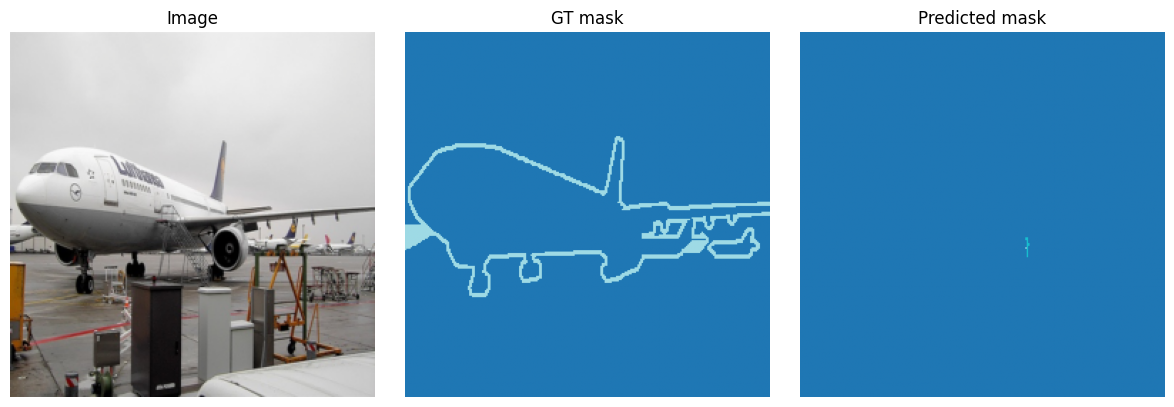

In [ ]:
model.eval()

mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
std  = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)

def visualize_sample(model, loader, device, idx_in_batch=0):
    model.to(device)

    imgs, masks = next(iter(loader))

    imgs  = imgs.to(device)
    masks = masks.to(device)

    with torch.no_grad():
        logits = model(imgs)
        preds  = torch.argmax(logits, dim=1)

    img  = imgs[idx_in_batch:idx_in_batch+1].cpu()
    mask = masks[idx_in_batch].cpu()
    pred = preds[idx_in_batch].cpu()

    img_denorm = img * std + mean
    img_denorm = img_denorm.clamp(0, 1)[0].permute(1, 2, 0).numpy()

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(img_denorm)
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(mask.numpy(), cmap="tab20")
    plt.title("GT mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pred.numpy(), cmap="tab20")
    plt.title("Predicted mask")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

visualize_sample(model, val_loader, device, idx_in_batch=0)

1. В чём заключается ключевое отличие U-Net от обычных CNN, таких как VGG?

Главная разница в том, что обычные CNN (например, VGG) хорошо подходят для классификации всего изображения, но плохо умеют восстанавливать точную карту пикселей. Они уменьшают изображение через пуллинг и теряют пространственные детали, а в конце дают один класс на всю картинку.

U-Net устроен по-другому:

1)в нём есть энкодер, как в обычной CNN - он уменьшает изображение и извлекает смысловые признаки;

2)но есть ещё декодер, который снова увеличивает разрешение до исходного размера;

3)самое важное - skip-connections: модель передаёт ранние, детальные признаки (края, формы) из энкодера прямо в декодер.

Получается, что U-Net одновременно понимает что на изображении (семантика) и где именно находится объект (локализация). Поэтому он хорошо подходит для сегментации.

2. Почему mIoU считается более строгой и предпочтительной метрикой, чем Pixel Accuracy?

Pixel Accuracy просто считает процент правильно угаданных пикселей.
Проблема в том, что в реальных изображениях много «простых» классов, например фон или небо. Если модель почти везде ставит фон, она может получить высокую точность, даже если плохо распознаёт маленькие объекты (пешеход, велосипед и т.д.).

mIoU работает иначе.
Она сравнивает накладывание областей:

IoU= объединение/пересечение
	​

То есть нужно не просто угадать пиксели, а угадать форму объекта, не пропустить его и не «рисовать лишнего».

mIoU учитывает и FP, и FN, поэтому если модель плохо сегментирует редкий класс -> IoU этого класса будет почти 0, а финальное среднее mIoU заметно упадёт

Поэтому mIoU честнее и строже - она показывает реальное качество сегментации, а не просто процент правильно угаданных пикселей.

В этой работе я реализовал задачу семантической сегментации, где нужно классифицировать каждый пиксель изображения. Для этого я использовал датасет Pascal VOC 2012 и модель U-Net с предобученным энкодером ResNet-34 (Transfer Learning). Это позволяет быстрее обучать модель и получать лучшее качество на небольшом количестве эпох.
На входе модель получала изображение, а на выходе — маску с предсказанием классов. В качестве функции потерь я использовал CrossEntropyLoss с ignore_index=255, чтобы игнорировать неопределённые пиксели. Для оценки качества применялись две метрики: Pixel Accuracy и mIoU.

Результаты обучения

Эпоха 1:
Train loss: 1.3030
Val loss: 0.9536
Pixel Acc: 0.7774
mIoU: 0.0741

Эпоха 2:
Train loss: 0.9403
Val loss: 0.8507
Pixel Acc: 0.7797
mIoU: 0.0777

Эпоха 3:
Train loss: 0.8440
Val loss: 0.7999
Pixel Acc: 0.7828
mIoU: 0.0876

Мы видим, что и loss, и метрики постепенно улучшаются - значит, модель обучается корректно. Pixel Accuracy довольно высокая (~78%), но mIoU остаётся маленьким, что нормально для VOC и малого числа эпох.

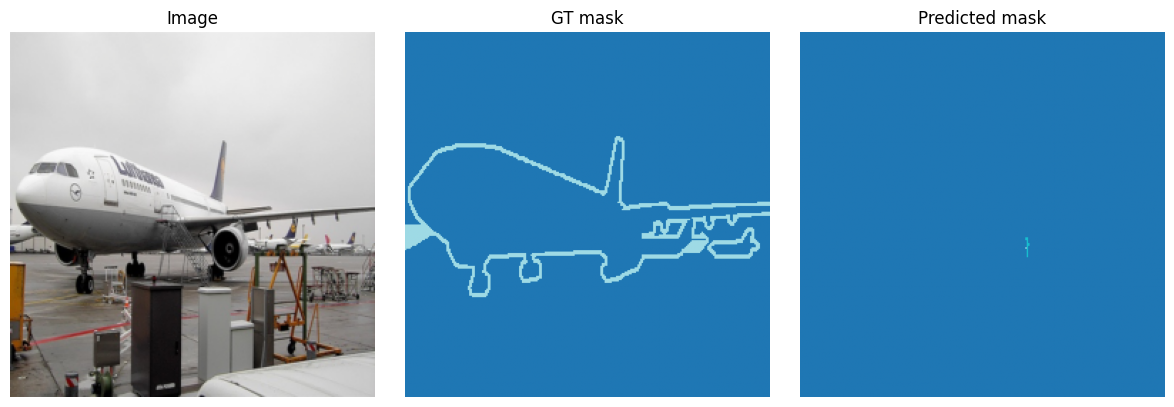

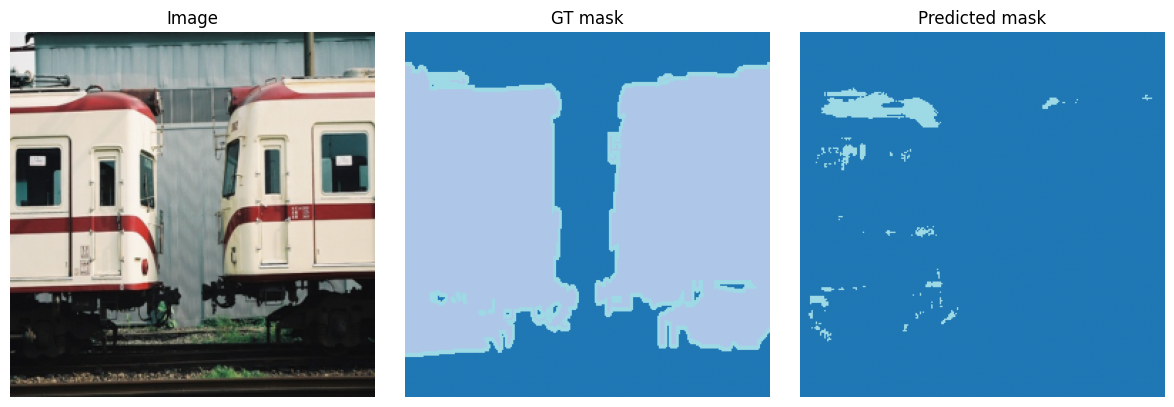

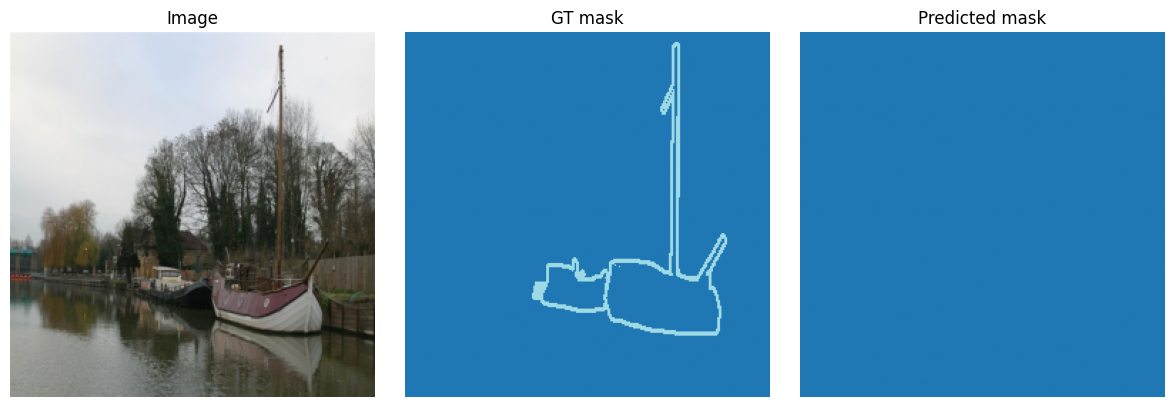

In [ ]:
visualize_sample(model, val_loader, device, idx_in_batch=0)
visualize_sample(model, val_loader, device, idx_in_batch=1)
visualize_sample(model, val_loader, device, idx_in_batch=2)


In [ ]:
# Дополнительный эксперимент:быстрое дообучение на подмножестве VOC

from copy import deepcopy
from torch.utils.data import DataLoader

small_train_dataset = VOCDataset("/content/data/VOC2012", "train")
small_val_dataset   = VOCDataset("/content/data/VOC2012", "val")

small_train_dataset.ids = small_train_dataset.ids[:1000]
small_val_dataset.ids   = small_val_dataset.ids[:200]

print("Размер поднабора: ", len(small_train_dataset), len(small_val_dataset))

small_train_loader = DataLoader(small_train_dataset, batch_size=8, shuffle=True,  num_workers=2)
small_val_loader   = DataLoader(small_val_dataset,   batch_size=8, shuffle=False, num_workers=2)

Размер поднабора:  1000 200


In [ ]:
EXTRA_EPOCHS = 5

for epoch in range(EXTRA_EPOCHS):
    train_loss = train_epoch(model, small_train_loader, optimizer, criterion, device)
    val_loss   = val_epoch(model, small_val_loader, criterion, device)
    pixel_acc, miou = evaluate_metrics(model, small_val_loader, device, num_classes=21, ignore_index=255)

    print(f"\n----- Доп. эпоха {epoch+1}/{EXTRA_EPOCHS} -----")
    print(f"Train loss: {train_loss:.4f}  Val loss: {val_loss:.4f}")
    print(f"Pixel Acc:  {pixel_acc:.4f}   mIoU: {miou:.4f}")

100%|██████████| 125/125 [20:46<00:00,  9.97s/it]



----- Доп. эпоха 1/5 -----
Train loss: 0.6712  Val loss: 0.7194
Pixel Acc:  0.8073   mIoU: 0.1227


100%|██████████| 125/125 [20:38<00:00,  9.90s/it]



----- Доп. эпоха 2/5 -----
Train loss: 0.6132  Val loss: 0.6842
Pixel Acc:  0.8070   mIoU: 0.1231


100%|██████████| 125/125 [20:28<00:00,  9.83s/it]



----- Доп. эпоха 3/5 -----
Train loss: 0.5693  Val loss: 0.6656
Pixel Acc:  0.8174   mIoU: 0.1486


100%|██████████| 125/125 [20:31<00:00,  9.85s/it]



----- Доп. эпоха 4/5 -----
Train loss: 0.5321  Val loss: 0.6468
Pixel Acc:  0.8258   mIoU: 0.1795


100%|██████████| 125/125 [20:31<00:00,  9.86s/it]



----- Доп. эпоха 5/5 -----
Train loss: 0.4992  Val loss: 0.6289
Pixel Acc:  0.8320   mIoU: 0.1982


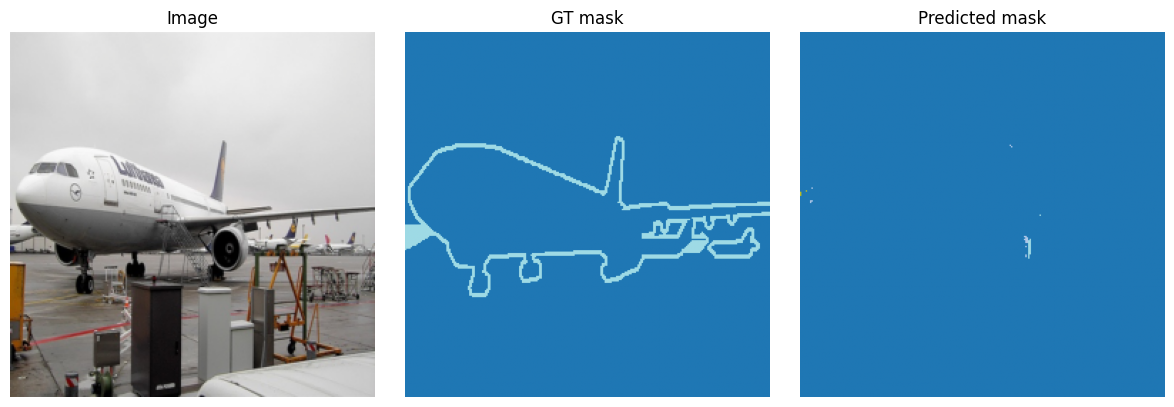

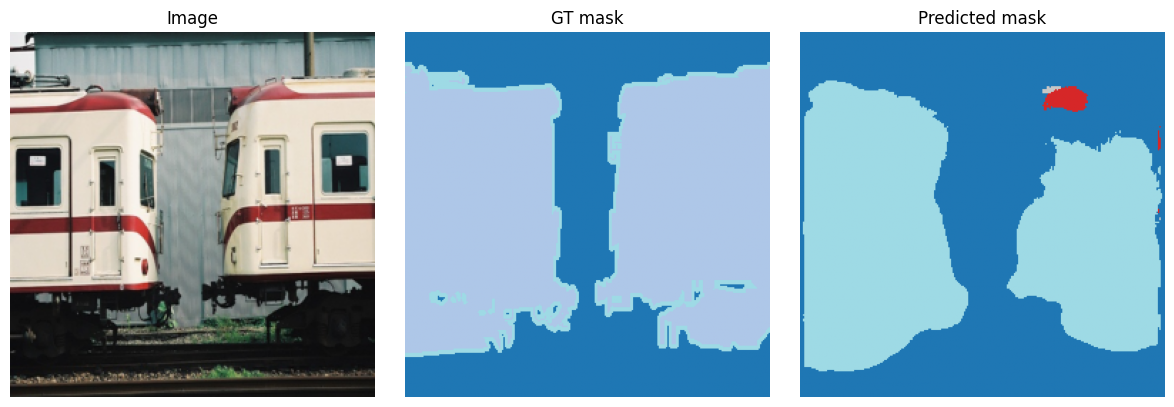

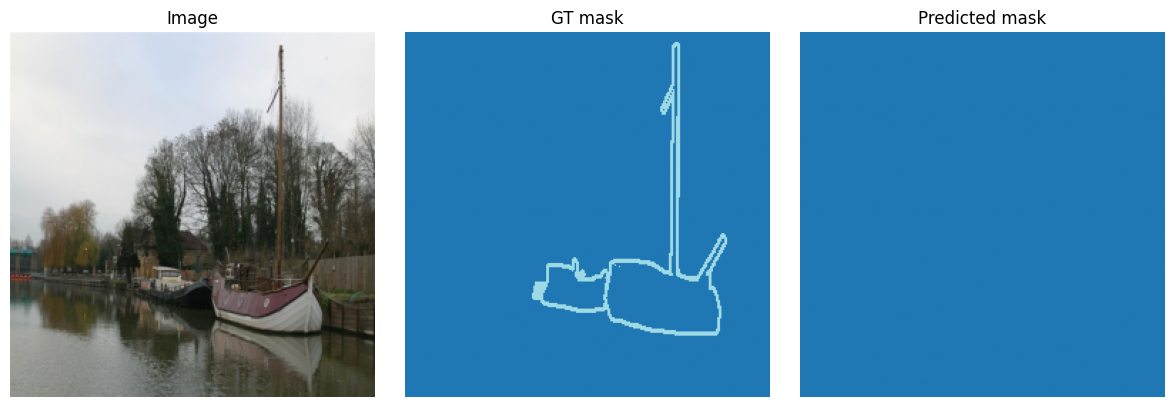

In [ ]:
for idx in range(3):
    visualize_sample(model, small_val_loader, device, idx_in_batch=idx)